In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import morphology
from skimage.measure import label

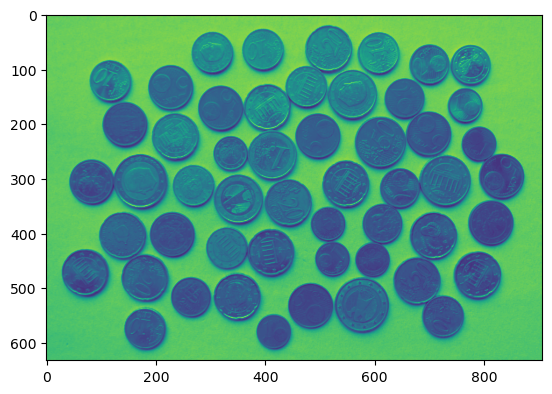

In [56]:
image = cv2.imread('coins.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(image)

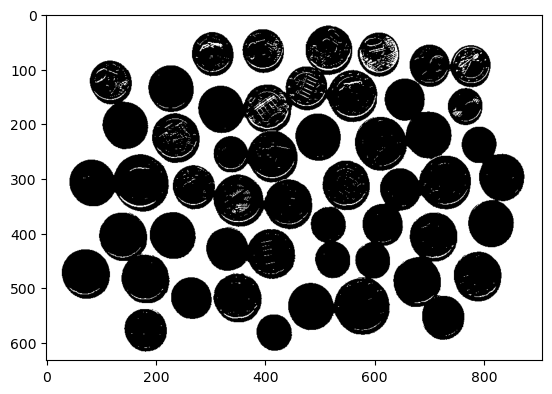

In [33]:
_, thresh_global = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
plt.imshow(thresh_global, cmap='gray')

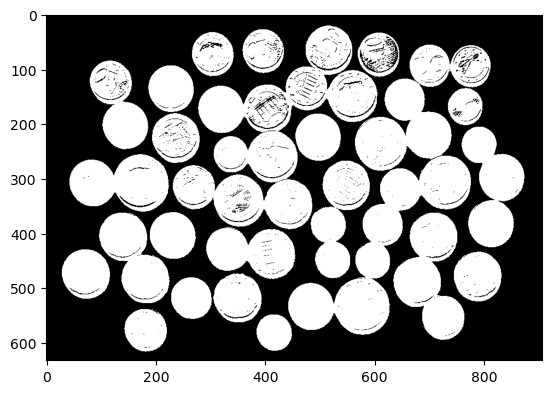

In [34]:
img_bitwise=cv2.bitwise_not(thresh_global)
plt.imshow(img_bitwise, cmap='gray')

In [35]:
img_bitwise.dtype

dtype('uint8')

In [36]:
np.unique(img_bitwise,return_counts=True)

(array([  0, 255], dtype=uint8), array([299735, 273489]))

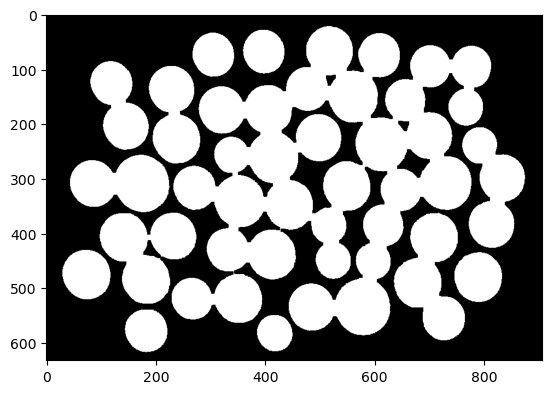

In [37]:
kernel = np.ones((6, 6), np.uint8)
 # Морфологическое закрытие
closing = cv2.morphologyEx(img_bitwise, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap='gray')

In [43]:
np.unique(closing,return_counts=True)

(array([0, 1]), array([289330, 283894]))

In [44]:
closing = np.where(closing>0,1,0)
np.unique(closing,return_counts=True)

(array([0, 1]), array([289330, 283894]))

 Compute Euclidean distance from every binary pixel to the nearest zero pixel then find peaks

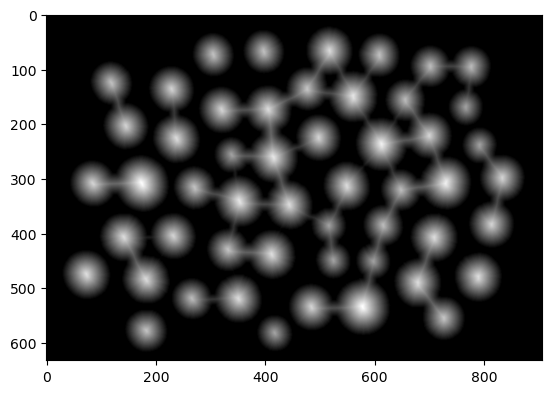

In [45]:
distance = ndi.distance_transform_edt(closing)
plt.imshow(distance, cmap='gray')

In [46]:
local_max = peak_local_max(distance, min_distance=30)
local_max.shape[0]

52

In [47]:
local_max.shape

(52, 2)

 Perform connected component analysis then apply Watershed


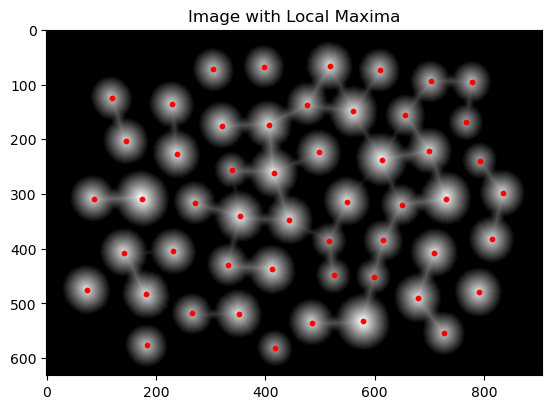

In [48]:
# Отобразите изображение с точками максимумов
plt.imshow(distance, cmap='gray')
plt.scatter(local_max[:, 1], local_max[:, 0], color='red', marker='o', s=10)  # Отметьте точки красными кругами
plt.title('Image with Local Maxima')
plt.show()

In [49]:
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(local_max.T)] = True
markers, _ = ndi.label(mask)

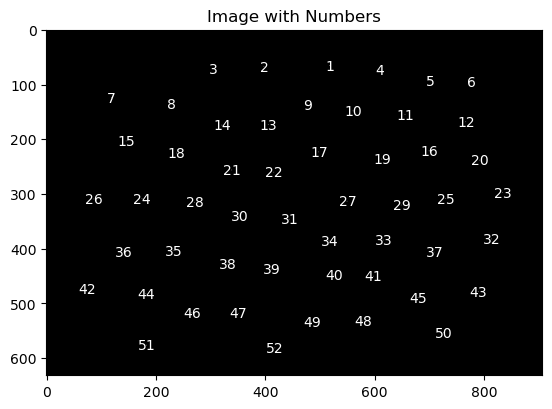

In [50]:
# Создайте изображение с черным фоном
image = np.zeros_like(markers, dtype=np.uint8)

# Установите белые точки на изображении
image[markers > 0] = 255

# Отобразите изображение
plt.imshow(image, cmap='gray')

# Добавьте числа рядом с белыми точками
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        if markers[i, j] > 0:
            plt.text(j, i, str(markers[i, j]), color='white', ha='center', va='center')

plt.title('Image with Numbers')
plt.show()

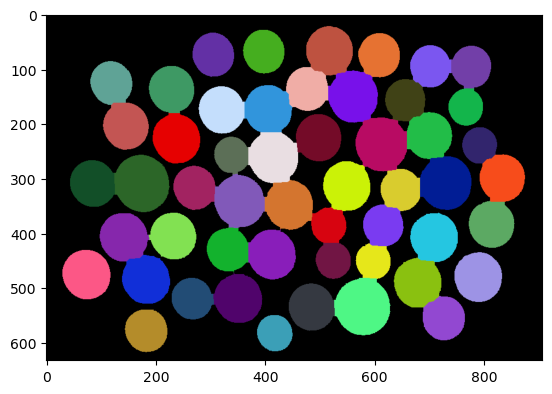

In [51]:
result_segmentation = watershed(-distance, markers, mask=closing)
# Укажите цвета для каждого объекта (от 1 до 52)
colors = np.random.rand(3)

# Отобразите каждый объект на изображении
image = np.zeros(result_segmentation.shape + (3,))
for i in range(1, 53):
    image[result_segmentation == i] =np.random.rand(3)

# Отобразите изображение
plt.imshow(image)
plt.show()

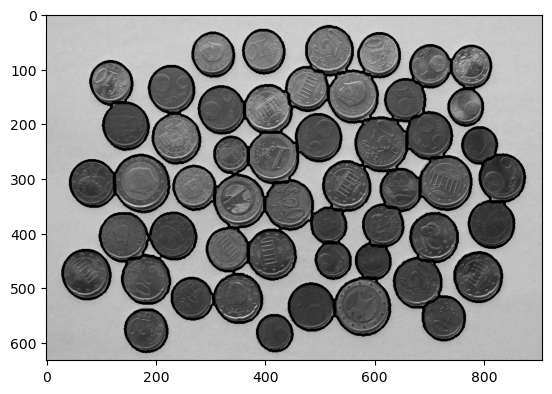

In [57]:
for label in np.unique(result_segmentation):
    if label == 0:
        continue
    mask = np.zeros(closing.shape, dtype="uint8")
    mask[result_segmentation == label] = 255
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    cv2.drawContours(image, cnts, -1, (0,255,0), 3)

plt.imshow(image, cmap='gray')

In [59]:
def watershedf(file,minDist=30,struct=(36,255,12),thickness=4):
    image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    imagec = cv2.imread(file)

    _, thresh_global = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    img_bitwise=cv2.bitwise_not(thresh_global)
    kernel = np.ones((6, 6), np.uint8)
    # Морфологическое закрытие
    closing = cv2.morphologyEx(img_bitwise, cv2.MORPH_CLOSE, kernel)
    closing = np.where(closing>0,1,0)
    distance = ndi.distance_transform_edt(closing)
    local_max = peak_local_max(distance, min_distance=minDist)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(local_max.T)] = True
    markers, _ = ndi.label(mask)

    result_segmentation = watershed(-distance, markers, mask=closing)
    # Укажите цвета для каждого объекта (от 1 до 52)

    for label in np.unique(result_segmentation):
        if label == 0:
            continue
        mask = np.zeros(closing.shape, dtype="uint8")
        mask[result_segmentation == label] = 255
        cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        
        cv2.drawContours(imagec, cnts, -1, struct, thickness)

    return imagec

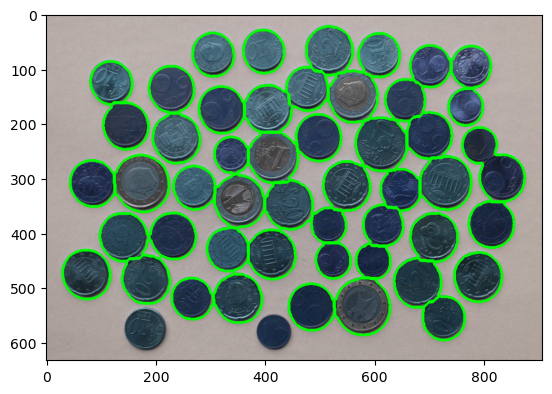

In [60]:
plt.imshow(watershedf('coins.png',minDist=55,struct=(0,255,0),thickness=3))
None

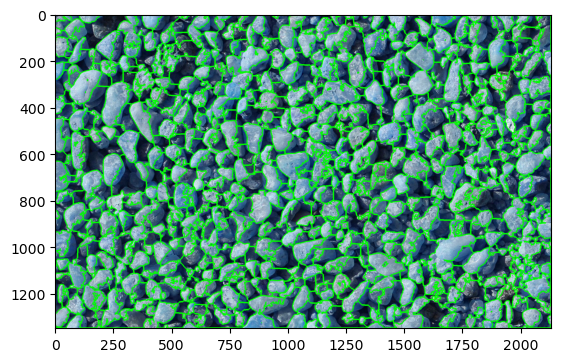

In [61]:
plt.imshow(watershedf('rocks.jpg',minDist=20,struct=(0,255,0),thickness=3))

In [76]:
image = cv2.imread('sponge.jpg')
plt.imsave('sponge1.jpg',image[40:110,25:160])

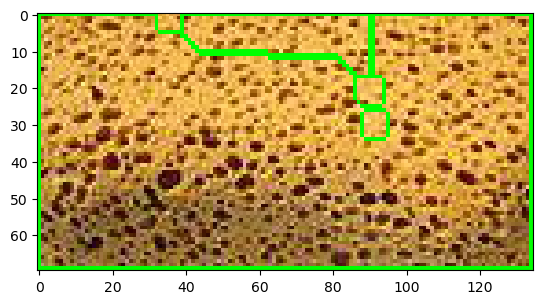

In [69]:
plt.imshow(watershedf('sponge1.jpg',minDist=2,struct=(0,255,0),thickness=1))

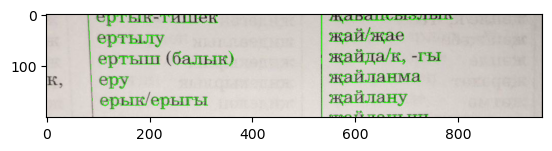

In [72]:
plt.imshow(watershedf('text.jpg',minDist=15,thickness=1)[400:600])

https://pyimagesearch.com/2015/11/02/watershed-opencv/